# R&U Data Analysis Report

## Import packages and Data-Cleaning

1. Import the tidyverse package of R
2. Extract the time lag between sending the SMS and making the phone call
3. Extract the month of each phone call

In [1]:
library(tidyverse)

data <- read_csv('R&U survey.csv')
data$days_lag <- as.Date(data$endtime, format="%Y/%m/%d")-
        as.Date(data$pf_tr_sms_sent_date, format="%d-%m-%Y")
data$sent_month <- strftime(as.Date(data$pf_tr_sms_sent_date, format="%d-%m-%Y"), "%m")

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
√ ggplot2 3.1.1       √ purrr   0.3.2  
√ tibble  2.1.1       √ dplyr   0.8.0.1
√ tidyr   0.8.3       √ stringr 1.4.0  
√ readr   1.3.1       √ forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Parsed with column specification:
cols(
  .default = col_double(),
  SubmissionDate = col_datetime(format = ""),
  starttime = col_datetime(format = ""),
  endtime = col_datetime(format = ""),
  simid = col_character(),
  caller_name = col_character(),
  pf_tr_cont_name = col_character(),
  pf_tr_sms_sent_date = col_character(),
  pf_tr_sms_content = col_character(),
  person_unavail_other = col_character(),
  rec_sms_from_CSH_flag_other = col_character(),
  msg_content = col_character(),
  read_msg_c

## 1. Find the distribution of call_status, indicating if a call is successfully made

0	Picked Up
<br>
1	Cut after few beeps
<br>
2	unreachable
<br>
3	Switched off
<br>
4	Wrong Number
<br>
5	Unanswered
<br>
6	Other
<br>


  0   1   2   3   4   5   6 
708  82  29 141 291 350 468 


         0          1          2          3          4          5          6 
0.30191898 0.03496802 0.01236674 0.06012793 0.12409382 0.14925373 0.19957356 

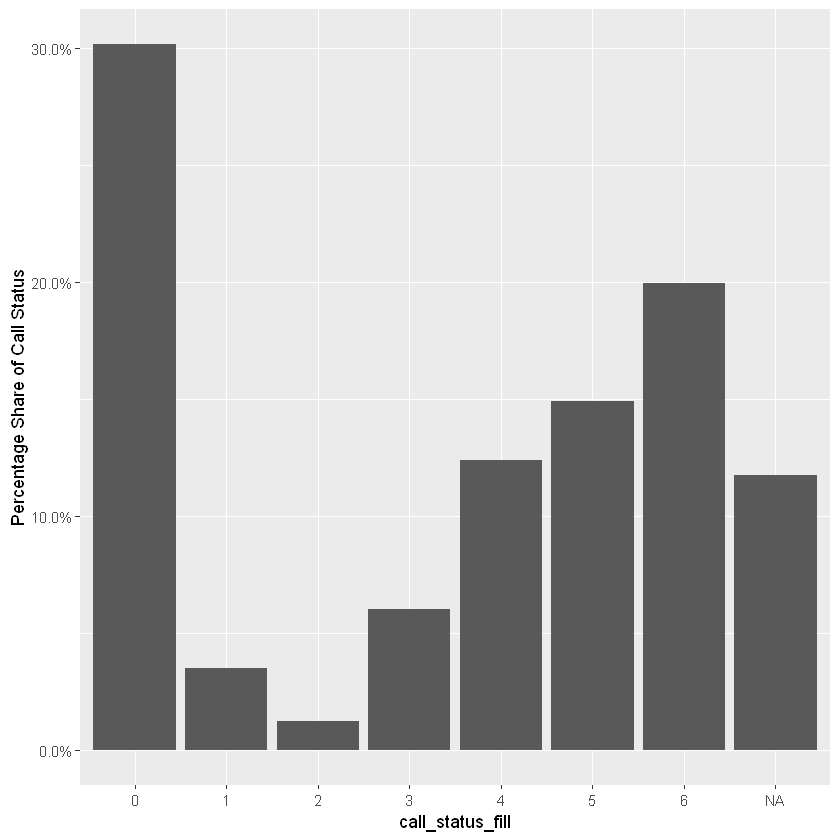

In [2]:
data$call_status_fill[data$call_status_fill==""] <- "NA"
table(data$call_status_fill)
table(data$call_status_fill)/length(data$call_status_fill)
ggplot(data, aes(x = call_status_fill)) +  
        geom_bar(aes(y = (..count..)/sum(..count..))) +
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Call Status")

Among 2345 calls collected, approximately 30% of the calls were picked up, and about 3% were cut after few beeps

## Filtering the data of answered calls, figuring out that only 708 out of 2,345 calls were answered, all of which happened in the month of July. I doubt if the surveyor successfully write down the call_status in phone calls in May and June?

In [3]:
data_answered <- subset(data, call_status_fill == "0") 
data.frame(table(data_answered$sent_month))

Var1,Freq
07,708


## 2. Find the distribution of the consent rate, indicating if the interviewee agreed to do the interview

0	No
<br>
1	Yes
<br>
2	Cannot talk as of now, Call back later
<br>
3	Phone cut in between while the surveyor is still talking
<br>


          0           1           2           3 
0.025423729 0.871468927 0.008474576 0.094632768 

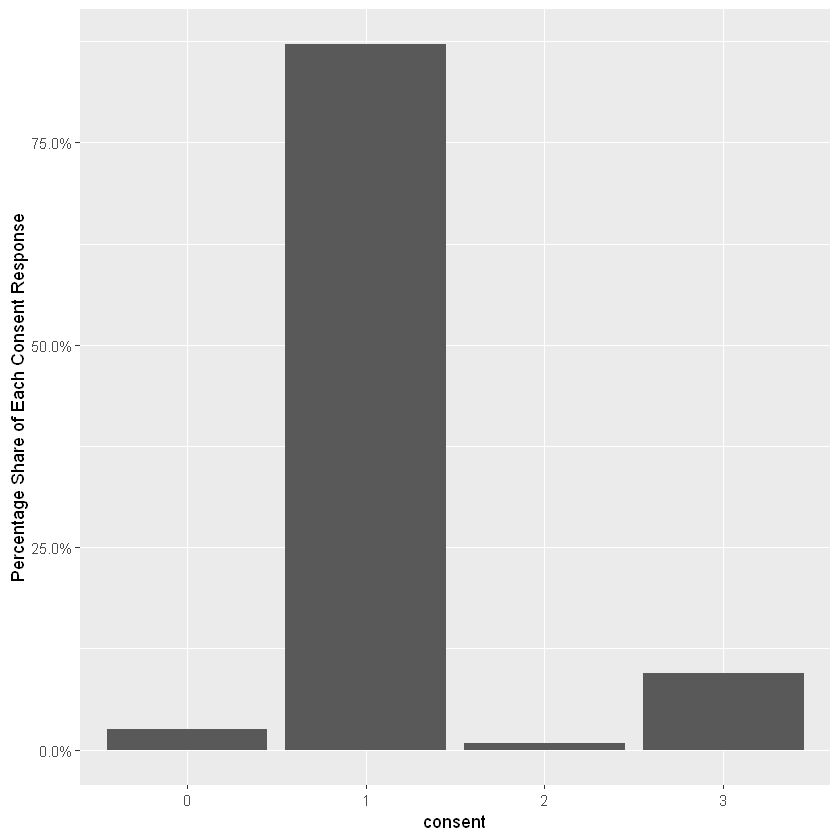

In [4]:
data_answered$consent <- as.character(data_answered$consent)
table(data_answered$consent)/length(data_answered$consent)
ggplot(data_answered, aes(x = consent)) +  
        geom_bar(aes(y = (..count..)/sum(..count..))) +
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Each Consent Response")

Among 708 answered calls, 87% agreed to do the phone interview, about 2.5% rejected, and about 9.4% cut in while the surveyor was still talking

In [5]:
# Filter the consented phone calls, which has 617 records out of 708 successful calls
data_consent <- subset(data_answered, consent == "1")

## 3. Find the distribution of the respondents' identities, indicating if the respondent is the initial contact

0	No
<br>
1	Yes
<br>
2	Wrong Number
<br>


  0   1   2 
367  87 163 

1 
0.1410049

0 
0.5948136

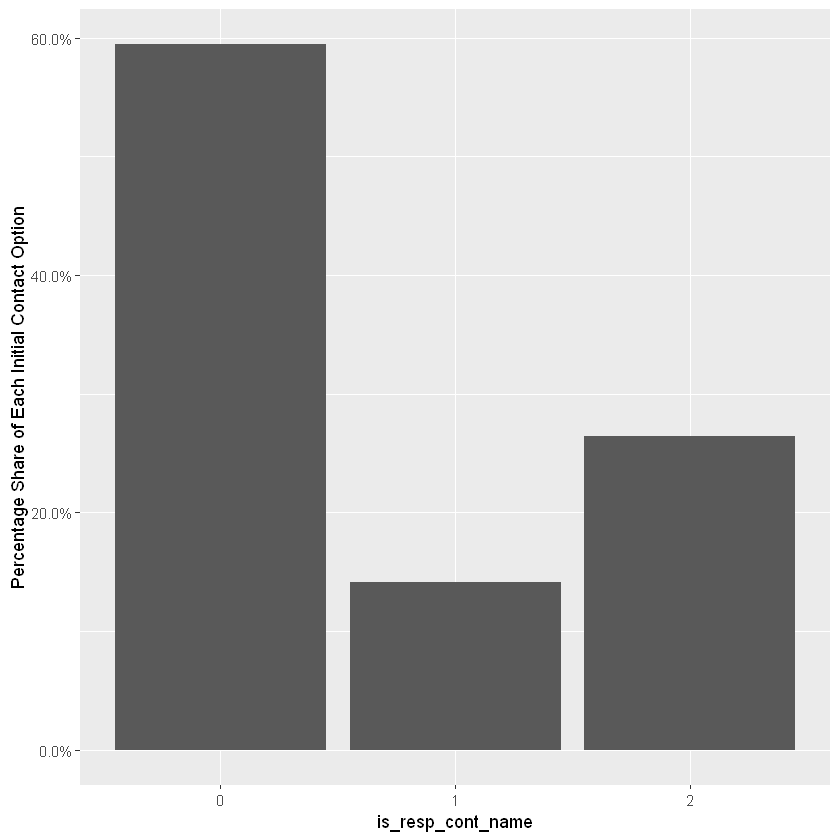

In [6]:
data_consent$is_resp_cont_name <- as.character(data_consent$is_resp_cont_name)
table(data_consent$is_resp_cont_name)
table(data_consent$is_resp_cont_name)["1"]/length(data_consent$is_resp_cont_name)
table(data_consent$is_resp_cont_name)["0"]/length(data_consent$is_resp_cont_name)
ggplot(data_consent, aes(x = is_resp_cont_name)) +  
        geom_bar(aes(y = (..count..)/sum(..count..))) +
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Each Initial Contact Option")

59% of the respondents are non-initial contacts, and 14% are initial contacts

## 4. Find the distribution of responses to requests of speaking to initial contacts

1	Yes
<br>
0	No
<br>


  0   1 
338  29 

0 
0.9209809

1 
0.07901907

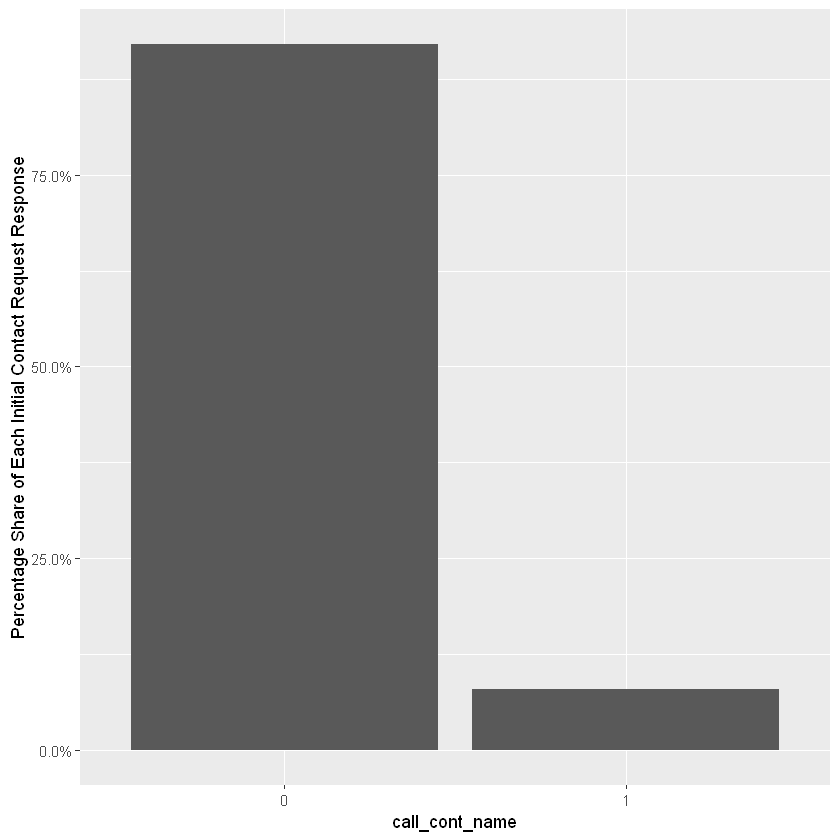

In [7]:
data_non_initial <- subset(data_consent, is_resp_cont_name == "0")
data_non_initial$call_cont_name <- as.character(data_non_initial$call_cont_name)
table(data_non_initial$call_cont_name)
table(data_non_initial$call_cont_name)["0"]/length(data_non_initial$call_cont_name)
table(data_non_initial$call_cont_name)["1"]/length(data_non_initial$call_cont_name)
ggplot(data_non_initial, aes(x = call_cont_name)) +  
        geom_bar(aes(y = (..count..)/sum(..count..))) +
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Each Initial Contact Request Response")

Among non initial contacts, 92% refused to give the phone to the initial contacts, and only 7.9% agreed

## 5. Find the distribution of reasons of refusing to let the initial contact speak

0	Not at home
<br>
1	Call Back later
<br>
2	I can talk on behalf of them
<br>
3	Wrong information, no person of such name lives here
<br>
4	Any other, specify:
<br>

In [8]:
data_cannot_speak <- subset(data_non_initial, call_cont_name == "0")
data_cannot_speak$person_unavail <- as.character(data_cannot_speak$person_unavail)
table(data_cannot_speak$person_unavail)
table(data_cannot_speak$person_unavail)/length(data_cannot_speak$person_unavail)


  0   1   2   3   4 
 50   1 200  13  74 


         0          1          2          3          4 
0.14792899 0.00295858 0.59171598 0.03846154 0.21893491 

Nearly 60% of the respondents claimed that they could talk on behalf of the initial contacts
<br>
Approximately 21% listed other reasons
<br>
About 14% said that the initial contacts are not home
<br>
The detailed information of "other reasons" is listed below

In [9]:
## Other reasons?
data.frame(table(data_cannot_speak$person_unavail_other))

Var1,Freq
Abhi neelam ji ke husband office me hai.....,1
Bahar,1
Bahar hai,1
Baher hai abhi jinke pas phone hai.....,1
Baher hai abhi.....,1
Cg,1
Child have been past away.....,1
Company me hai jinke pas mobile hai.....,1
Court me hai.....,1
D,1


## 6. Find the distribution of their relation to the initial contact

0	I am her Husband
<br>
1	I am her Mother in Law
<br>
2	I am her Father in Law
<br>
3	I am her Brother in Law
<br>
4	I am her Sister in Law
<br>
5	Any other
<br>

In [10]:
table(data_non_initial$rel_with_mother)/length(data_non_initial$rel_with_mother)


          0           1           2           3           4           5 
0.585831063 0.008174387 0.029972752 0.029972752 0.002724796 0.228882834 

Among non initial contacts, 58% are husbands, nearly 23% are others

## 7. Refuse reasons break down by relations

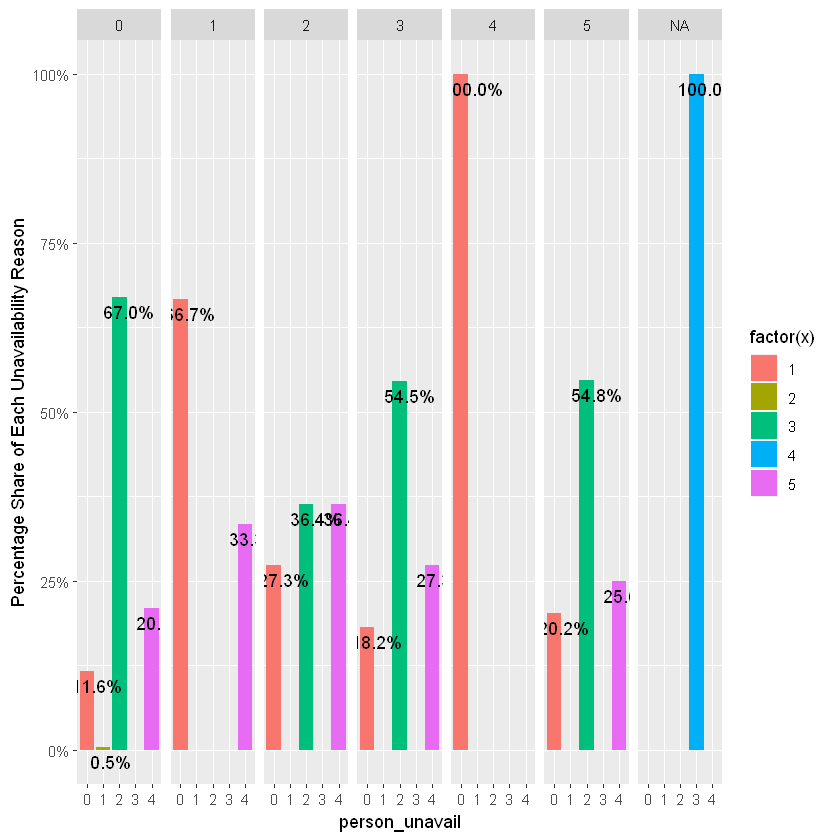

In [11]:
ggplot(data_cannot_speak, aes(x = person_unavail, group=rel_with_mother)) +  
        geom_bar(aes(y = ..prop.., fill = factor(..x..)), stat="count") +
        geom_text(aes( label = scales::percent(..prop..),
                       y= ..prop.. ,hjust=0.3, vjust=1.5), stat= "count")+
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Each Unavailability Reason") +
        facet_grid(~rel_with_mother)


## 0 Not at home 
## 1 Call Back later 
## 2 I can talk on behalf of them 
## 3 Wrong information, no person of such name lives here 
## 4 Any other, specify:

It is observed that 67% husbands said that they could talk on behalf of initial contacts
<br>
66.7% of mothers in law said that the initial contacts were not at home
<br>
100% of sisters in law said that the initial contacts were not at home
<br>

## Combine the analysis records:
<br>
Group 1: "Yes, I am..."
<br>
Group 2: "I am not ..., but you can speak with ..."
<br>
Group 3: "I am not ..., and you cannot speak with..., but I can talk on her behalf"
<br>

In [12]:
group_1 <- subset(data_consent, is_resp_cont_name == "1")
group_1$type <- "Initial Contact Mom"
group_2 <- subset(data_consent, (is_resp_cont_name == "0") & (call_cont_name == "1"))
group_2$type <- "Initial Contact Mom"
group_3 <- subset(
        data_consent, (is_resp_cont_name == "0") & (call_cont_name == "0") & (
                person_unavail == "2"))
group_3$type <- "Family Member on Her Behalf"
analysis_group <- bind_rows(group_1, group_2, group_3)
## We create another variable "type" that indicates if the interviewee is the initial contact

In [13]:
nrow(analysis_group)
## 316 records in data are eligible for analysis

[1] 316

## 8. Distribution of the responses to the question "Did you receive the message from us?"

0	Yes, I am sure I received an SMS
<br>
1	Yes, I vaguely remember receiving an SMS
<br>
2	No, I did not receive an SMS
<br>
3	As far as I remember I deleted all the messages
<br>
5	I don't know
<br>
4	Any other
<br>


          0           1           2           3           4           5 
0.382911392 0.009493671 0.348101266 0.031645570 0.022151899 0.205696203 

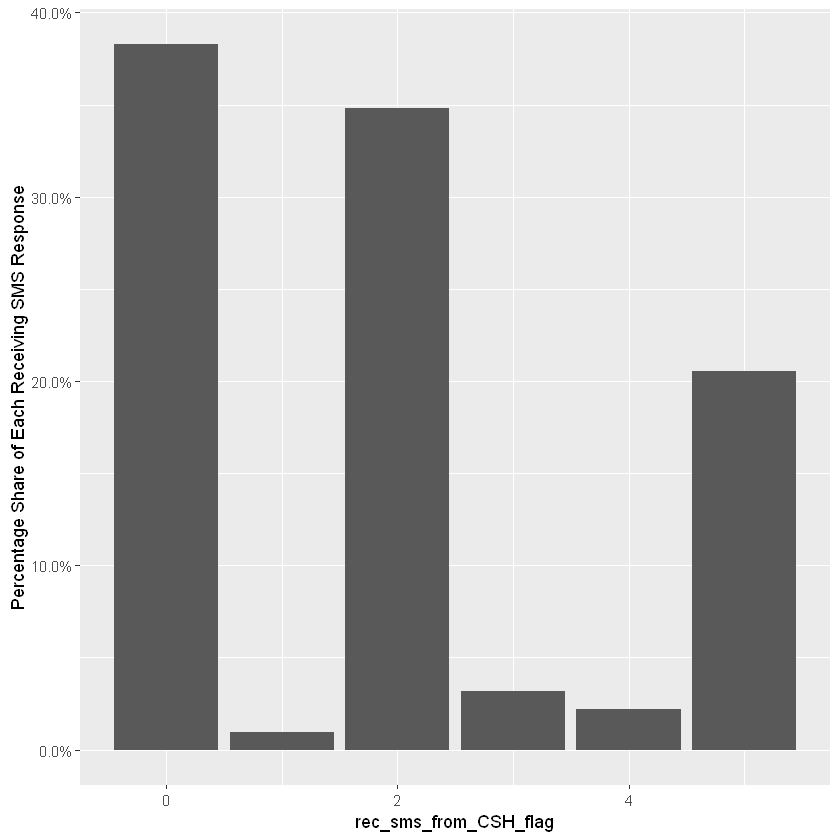

In [14]:
table(analysis_group$rec_sms_from_CSH_flag)/length(analysis_group$rec_sms_from_CSH_flag)
ggplot(analysis_group, aes(x = rec_sms_from_CSH_flag)) +  
        geom_bar(aes(y = (..count..)/sum(..count..))) +
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Each Receiving SMS Response")

38.29% said absolute yes, 34.81% said no, and 20.56% said "I don't know"

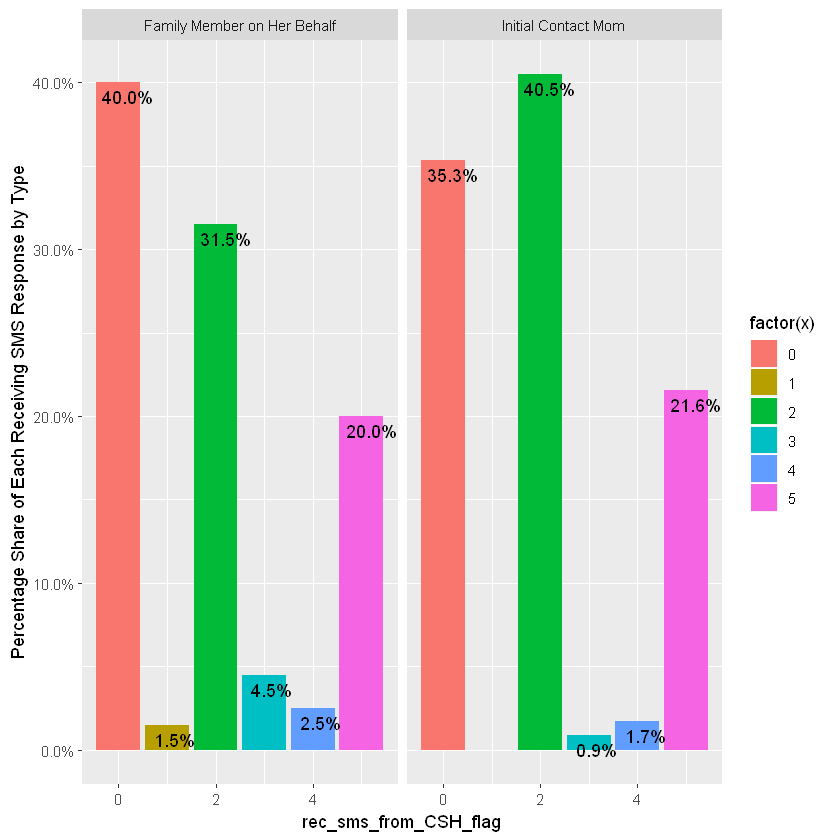

In [15]:
## Same distribution break down by type (initial contact vs. non initial contact)

ggplot(analysis_group, aes(x = rec_sms_from_CSH_flag, group=type)) +  
        geom_bar(aes(y = ..prop.., fill = factor(..x..)), stat="count") +
        geom_text(aes( label = scales::percent(..prop..),
                       y= ..prop.. ,hjust=0.3, vjust=1.5), stat= "count")+
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Each Receiving SMS Response by Type") +
        facet_grid(~type)

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


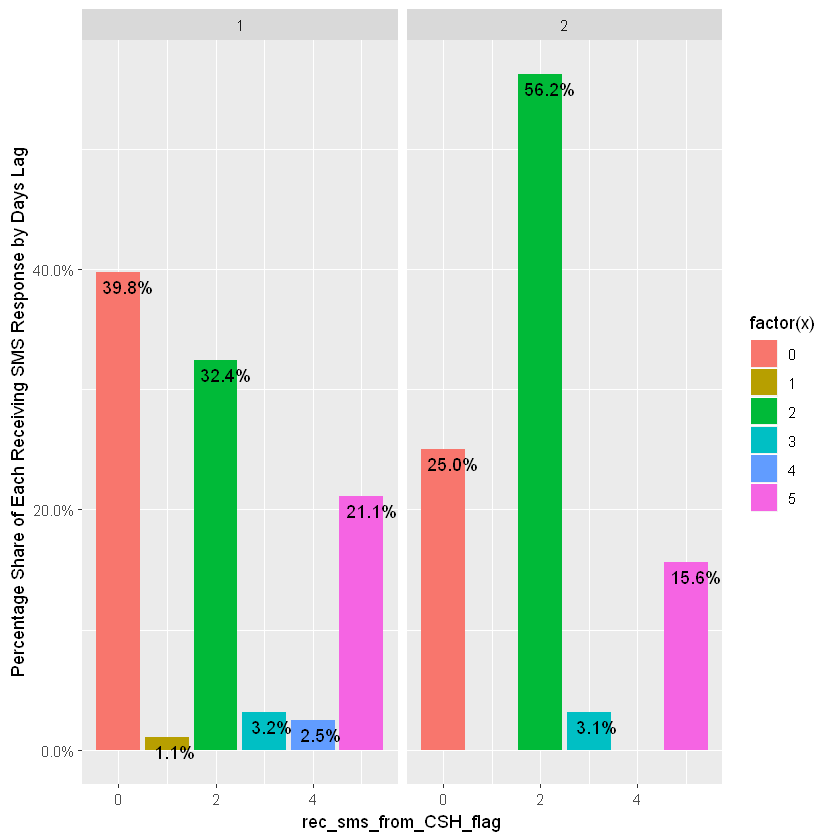

In [16]:
## Same distribution break down by days lag (how many days was the interview conducted after sending the SMS)

ggplot(analysis_group, aes(x = rec_sms_from_CSH_flag, group=days_lag)) +  
        geom_bar(aes(y = ..prop.., fill = factor(..x..)), stat="count") +
        geom_text(aes( label = scales::percent(..prop..),
                       y= ..prop.. ,hjust=0.3, vjust=1.5), stat= "count")+
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Each Receiving SMS Response by Days Lag") +
        facet_grid(~days_lag)

In [17]:
## Other responses to the above question?
data.frame(table(analysis_group$rec_sms_from_CSH_flag_other))

Var1,Freq
Abhi check karke batata hu,1
Call back later,1
Network issue ke karan bat nahi ho paya.....,1
Respondent busy,1
Respondent language is diffrent,1
The child has been past.....,1


## 9. Distribution of the responses to the question "Please specify why don't know?"

0	I don't know because I delete all my messages.
<br>
1	I don't know because this is not my phone.
<br>
3	I don't know because someone else checks the messages for them
<br>
4	I don't know because I never check my messages
<br>
5	I don't know because I don't remember
<br>
6	Any other
<br>

In [18]:
analysis_dontknow <- subset(analysis_group, rec_sms_from_CSH_flag == 5)
table(analysis_dontknow$rec_sms_from_CSH_flag_dont_know)/length(
        analysis_dontknow$rec_sms_from_CSH_flag_dont_know)


         0          1          4          5          6 
0.03076923 0.12307692 0.46153846 0.20000000 0.18461538 

12.3% said they don't know because its not their phone
<br>
46.15% said they don't know because they never check messages
<br>
20% said they don't know because they don't remember

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


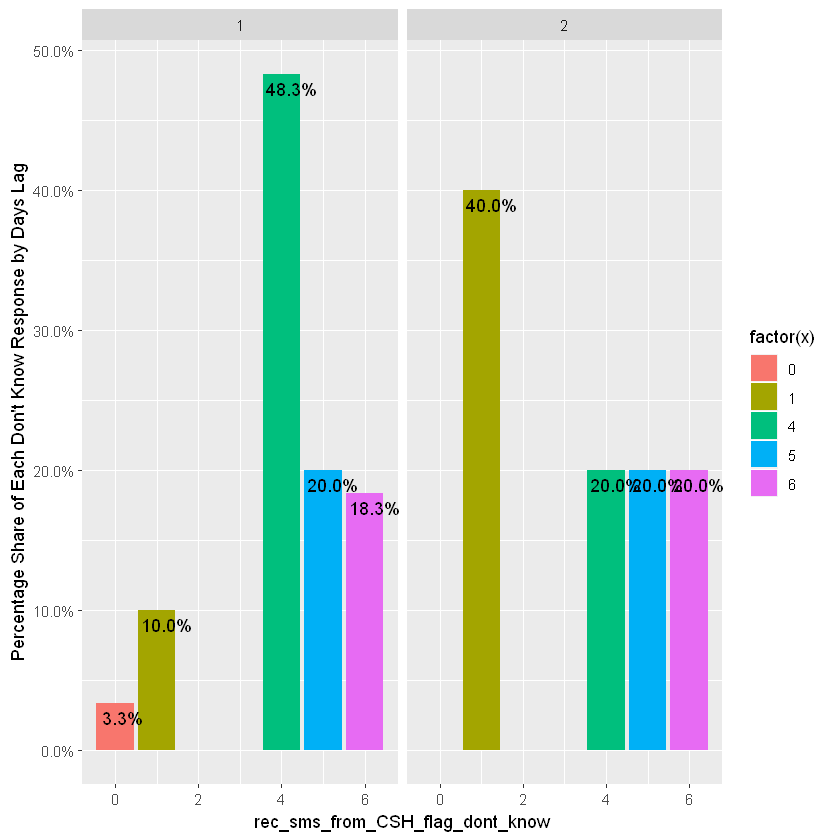

In [19]:
## Don't know responses break down by time lag (how many days was the interview conducted after sending the SMS)

ggplot(analysis_dontknow, aes(x = rec_sms_from_CSH_flag_dont_know, group=days_lag)) +  
        geom_bar(aes(y = ..prop.., fill = factor(..x..)), stat="count") +
        geom_text(aes( label = scales::percent(..prop..),
                       y= ..prop.. ,hjust=0.3, vjust=1.5), stat= "count")+
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Each Don't Know Response by Days Lag") +
        facet_grid(~days_lag)

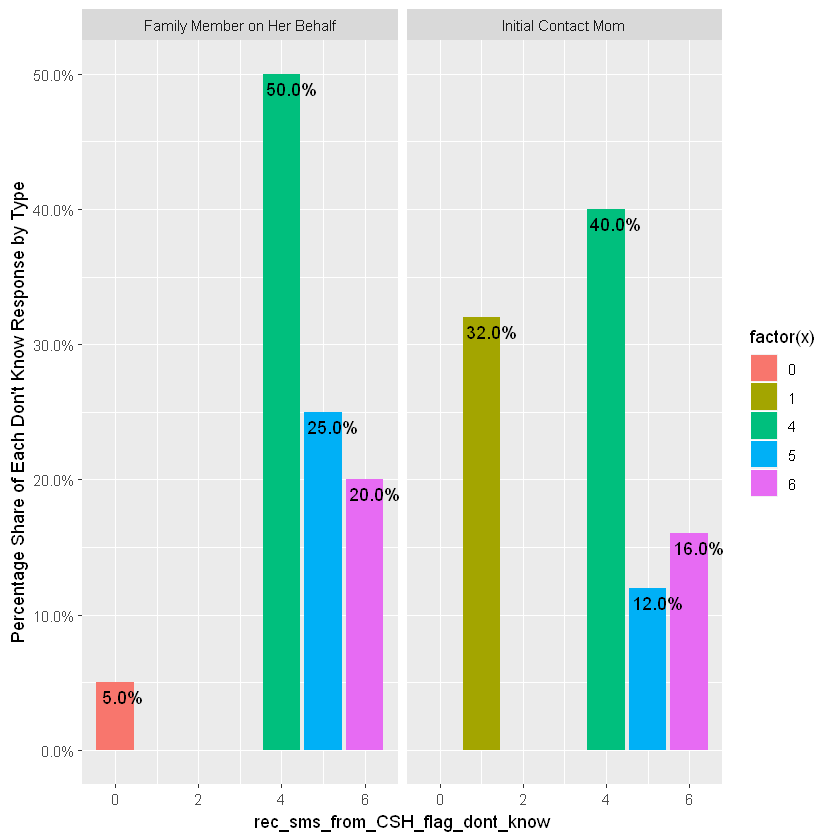

In [20]:
## Don't know responses break down by type(initial contact vs. non-initial contact)

ggplot(analysis_dontknow, aes(x = rec_sms_from_CSH_flag_dont_know, group=type)) +  
        geom_bar(aes(y = ..prop.., fill = factor(..x..)), stat="count") +
        geom_text(aes( label = scales::percent(..prop..),
                       y= ..prop.. ,hjust=0.3, vjust=1.5), stat= "count")+
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Each Don't Know Response by Type") +
        facet_grid(~type)

## 10. If you receive the SMS from us, can you remember the message content?

0 No
<br>
1 Yes


        0         1 
0.2903226 0.7096774 

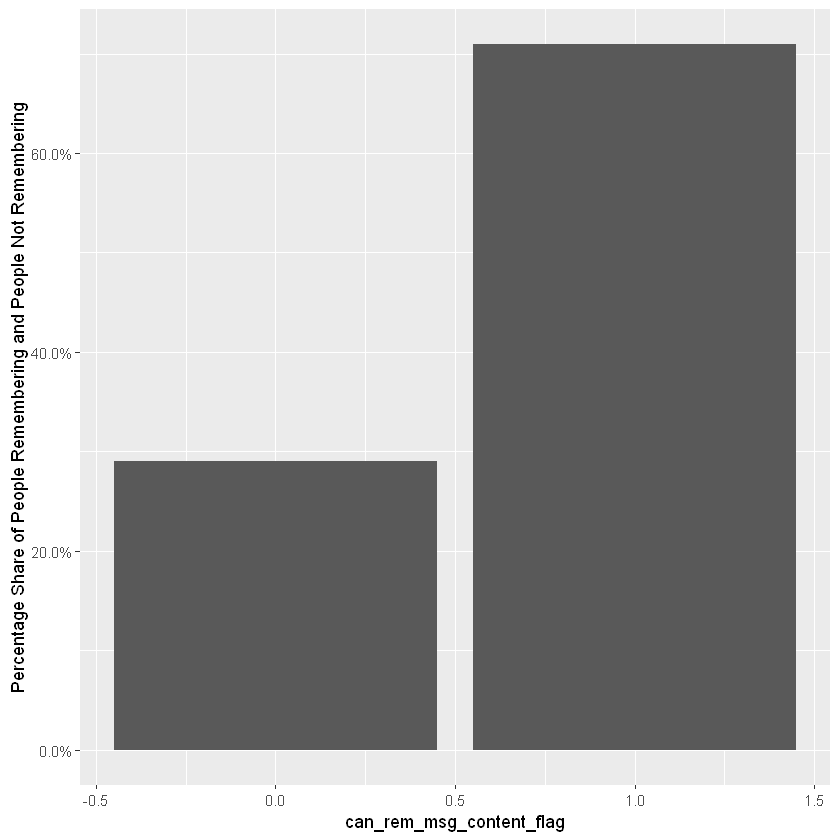

In [21]:
analysis_received <- subset(
        analysis_group, (
                rec_sms_from_CSH_flag == "0") | (rec_sms_from_CSH_flag == "1"))
table(analysis_received$can_rem_msg_content_flag)/length(
        analysis_received$can_rem_msg_content_flag)
ggplot(analysis_received, aes(x = can_rem_msg_content_flag)) +  
        geom_bar(aes(y = (..count..)/sum(..count..))) +
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of People Remembering and People Not Remembering")

Among those who claimed that they received the SMS, approximately 71% of them said they could remember the content of the SMS

## 10. If you could not remember, why?

1	I receive many messages, so I don't read carefully
<br>
2	Any other
<br>

In [22]:
analysis_noremember <- subset(analysis_received, can_rem_msg_content_flag == "0")
table(analysis_noremember$cannot_rem_msg_content)/length(
        analysis_noremember$cannot_rem_msg_content)


        1         2 
0.3055556 0.6944444 

More than 30% said that they receive so many messages, so they do not read carefully

## 11. If you remember, what did the message say?

0	Vaccination
<br>
1	Time for
<br>
2	Due
<br>
3	1 week/1 day
<br>
4	Go to
<br>
5	ASHA/Anganwadi/Health Center
<br>
6	Any Other
<br>
7	None of the above
<br>

In [23]:
analysis_remember <- subset(analysis_received, can_rem_msg_content_flag == "1")
table(analysis_remember$msg_content)/length(analysis_remember$msg_content)


         0    0 2 3 6        0 3    0 3 4 6        0 4        0 6   2000 3 6 
0.10227273 0.01136364 0.22727273 0.01136364 0.01136364 0.25000000 0.34090909 
  2000 6 7          6 
0.01136364 0.03409091 

34.09% said they remember "vaccination, due, 1 week/1 day, any other"
<br>
25% said they remember "vaccination, any other"
<br>
22.72% said they remember "vaccination, 1 week/1 day"
<br>

## 12. Distribution of responses to "do you sometimes delete SMS"?

0 No
<br>
1 Yes
<br>


        0         1 
0.1930380 0.1550633 

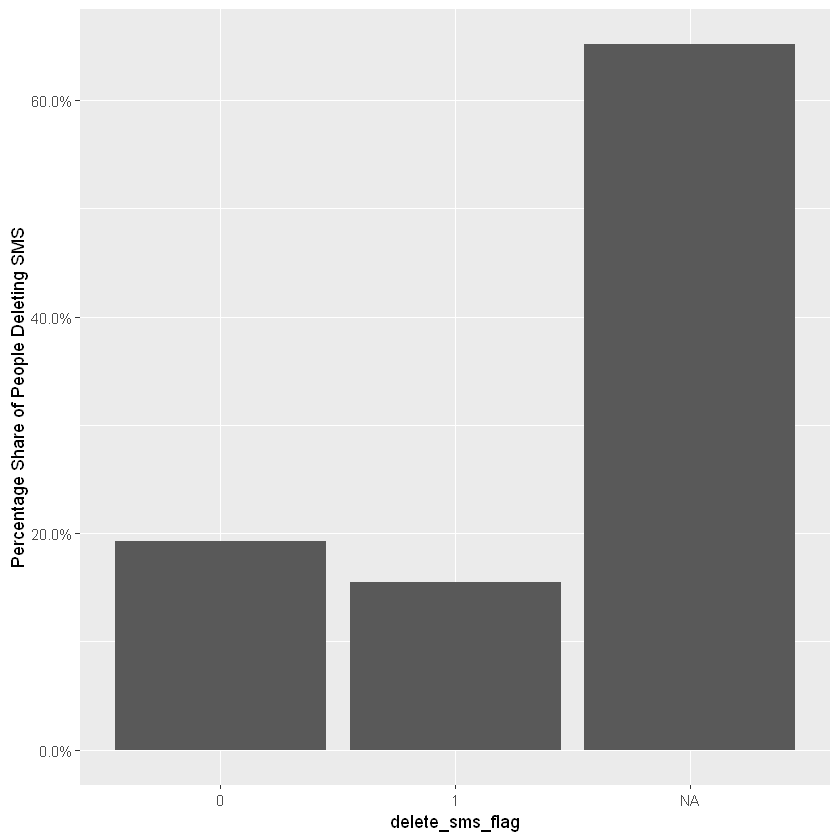

In [24]:
analysis_group$delete_sms_flag[analysis_group$delete_sms_flag==""] <- "NA"
table(analysis_group$delete_sms_flag)/length(analysis_group$delete_sms_flag)
ggplot(analysis_group, aes(x = delete_sms_flag)) +  
        geom_bar(aes(y = (..count..)/sum(..count..))) +
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of People Deleting SMS")

15% said yes
<br>
19% said no
<br>
the rest are missing data

## 12. Distribution of responses to "Please check inbox, did you find the SMS?"

0	No, I did not find such an SMS in my inbox
<br>
1	Yes,  I found such an SMS in my inbox
<br>
2	Do not know how to check
<br>
3	Do not want to check
<br>


          0           1           2           3 
0.047468354 0.253164557 0.009493671 0.082278481 

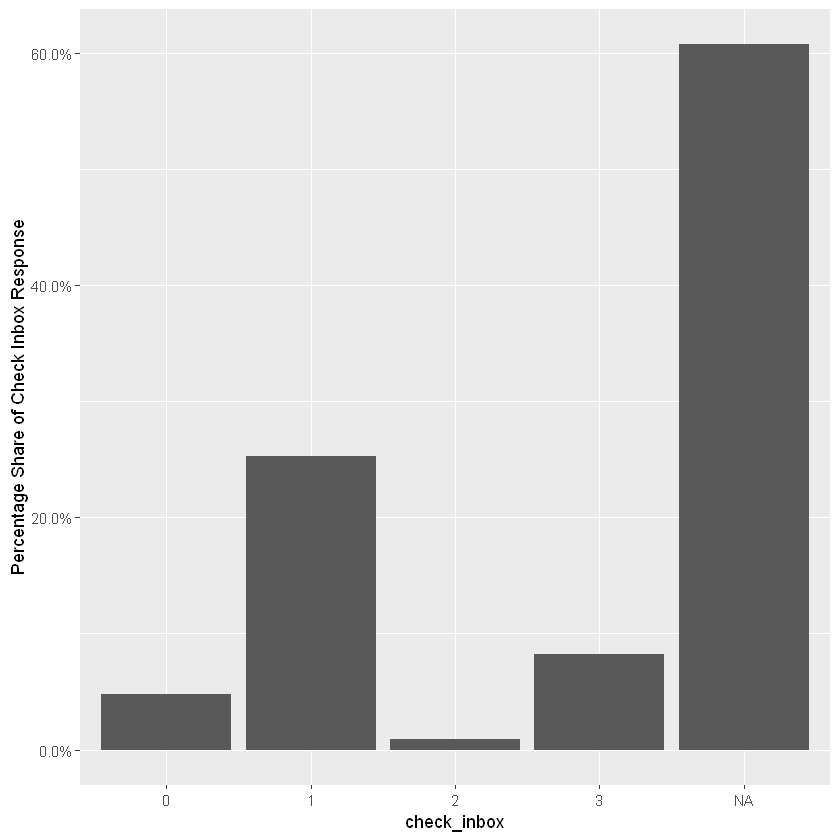

In [25]:
analysis_group$check_inbox[analysis_group$check_inbox==""] <- "NA"
table(analysis_group$check_inbox)/length(analysis_group$check_inbox)
ggplot(analysis_group, aes(x = check_inbox)) +  
        geom_bar(aes(y = (..count..)/sum(..count..))) +
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Check Inbox Response")

25.3% of the eligible records said "Yes, I did find the SMS"

## 13. Distribution of responses to the question "can you read the content?"

0 No
<br>
1 Yes
<br>


     0      1 
0.0875 0.9125 

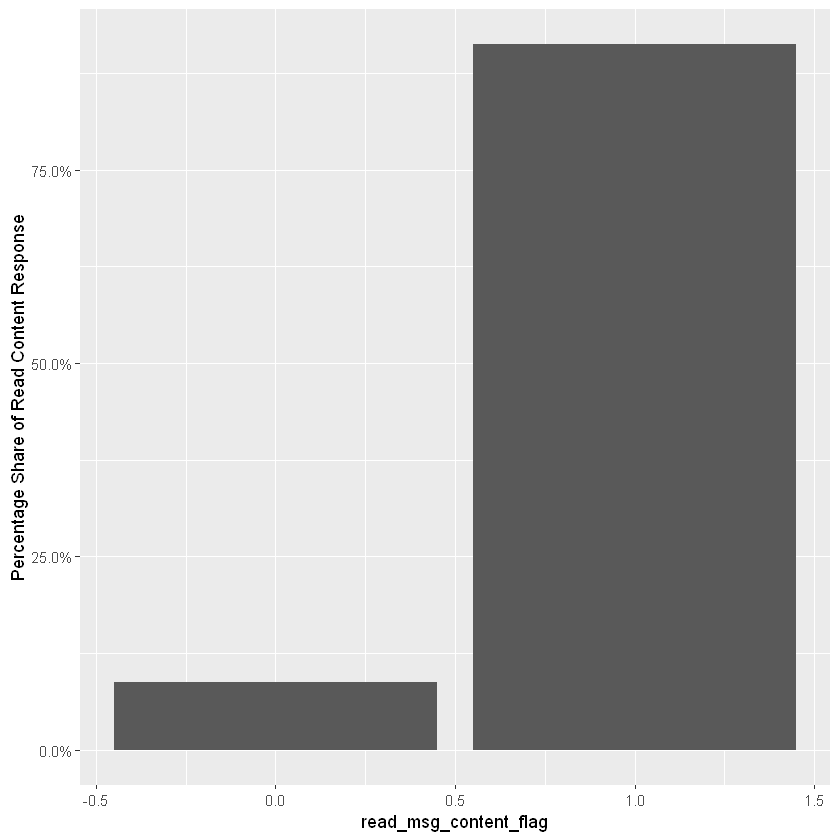

In [26]:
analysis_check_receive <- subset(analysis_group, check_inbox == "1")
table(analysis_check_receive$read_msg_content_flag)/length(analysis_check_receive$read_msg_content_flag)
ggplot(analysis_check_receive, aes(x = read_msg_content_flag)) +  
        geom_bar(aes(y = (..count..)/sum(..count..))) +
        scale_y_continuous(labels=scales::percent) +
        ylab("Percentage Share of Read Content Response")

Among those who checked inbox and received the SMS, more than 91% of them said "Yes, I can read the content"

## 14. Distribution of responses to the question "What can you read from the content?"

0 Vaccination
<br>
1 Time for 
<br>
2 Due 
<br>
3 1 week/1 day 
<br>
4 Go to 
<br>
5 ASHA/Anganwadi/Health Center 
<br>
6 Any Other 
<br>
7 None of the above 
<br>

In [27]:
analysis_check_receive$read_msg_content[analysis_check_receive$read_msg_content==""] <- 'NA'
table(analysis_check_receive$read_msg_content)/length(analysis_check_receive$read_msg_content)


       0      0 3  0 3 4 6      0 6 1 3 2006 2000 1 3 2000 3 6 2000 6 7 
  0.0375   0.1625   0.0250   0.2125   0.0125   0.0125   0.4250   0.0125 
     3 6 
  0.0125 

Among those who received the message, 42.5% of them said they could read "vaccination, due, 1 week/1 day, any other"
<br>
21.25% of them said they could read "vaccination, any other"
<br>
16.25% of them said they could read "vaccination, 1 week/1 day"